# 06 - Hyperparameter Tuning & Model Optimization
## Heart Disease UCI Dataset

### Objectives:
- Apply GridSearchCV for exhaustive hyperparameter optimization
- Use RandomizedSearchCV for efficient parameter search
- Optimize best performing models from supervised learning
- Compare optimized vs baseline model performance
- Select final optimized model for deployment

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from scipy.stats import randint, uniform
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print(" Libraries imported successfully!")

 Libraries imported successfully!


## 2. Load Data and Baseline Models

In [2]:
def load_data_and_models():
    """Load training data and baseline models"""
    try:
        # Load feature-selected data
        X_train = pd.read_csv('../data/X_train_selected.csv')
        X_test = pd.read_csv('../data/X_test_selected.csv')
        y_train = pd.read_csv('../data/y_train.csv').squeeze()
        y_test = pd.read_csv('../data/y_test.csv').squeeze()
        
        print(" Loaded feature-selected data")
        
    except FileNotFoundError:
        # Fallback to original data
        X_train = pd.read_csv('../data/X_train.csv')
        X_test = pd.read_csv('../data/X_test.csv')
        y_train = pd.read_csv('../data/y_train.csv').squeeze()
        y_test = pd.read_csv('../data/y_test.csv').squeeze()
        print(" Loaded original preprocessed data")
    
    # Load baseline models
    baseline_models = {}
    model_files = [
        'logistic_regression_model.pkl',
        'decision_tree_model.pkl', 
        'random_forest_model.pkl',
        'support_vector_machine_model.pkl'
    ]
    
    for model_file in model_files:
        try:
            model_name = model_file.replace('_model.pkl', '').replace('_', ' ').title()
            model = joblib.load(f'../models/{model_file}')
            baseline_models[model_name] = model
            print(f" Loaded {model_name}")
        except FileNotFoundError:
            print(f" {model_file} not found")
    
    return X_train, X_test, y_train, y_test, baseline_models

# Load data and models
X_train, X_test, y_train, y_test, baseline_models = load_data_and_models()

print(f"\n Dataset Summary:")
print(f"   Training set: {X_train.shape}")
print(f"   Testing set: {X_test.shape}")
print(f"   Features: {list(X_train.columns)}")
print(f"   Baseline models loaded: {list(baseline_models.keys())}")

 Loaded feature-selected data
 Loaded Logistic Regression
 Loaded Decision Tree
 Loaded Random Forest
 Loaded Support Vector Machine

 Dataset Summary:
   Training set: (736, 8)
   Testing set: (184, 8)
   Features: ['cp', 'thalach', 'exang', 'oldpeak', 'chol', 'thal', 'age', 'sex']
   Baseline models loaded: ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Support Vector Machine']


## 3. Evaluate Baseline Performance

In [3]:
print("=== BASELINE MODEL PERFORMANCE ===\n")

baseline_results = {}

for model_name, model in baseline_models.items():
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    baseline_results[model_name] = {
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'cv_mean': cv_mean,
        'cv_std': cv_std
    }
    
    print(f"{model_name:25} | Accuracy: {accuracy:.4f} | F1-Score: {f1:.4f} | CV: {cv_mean:.4f} ± {cv_std:.4f}")

# Create baseline results DataFrame
baseline_df = pd.DataFrame(baseline_results).T
baseline_df = baseline_df.sort_values('f1_score', ascending=False)

best_baseline_model = baseline_df.index[0]
print(f"\n BEST BASELINE MODEL: {best_baseline_model}")
print(f"   F1-Score: {baseline_df.loc[best_baseline_model, 'f1_score']:.4f}")
print(f"   Accuracy: {baseline_df.loc[best_baseline_model, 'accuracy']:.4f}")

=== BASELINE MODEL PERFORMANCE ===

Logistic Regression       | Accuracy: 0.5707 | F1-Score: 0.5429 | CV: 0.5611 ± 0.0330
Decision Tree             | Accuracy: 0.5109 | F1-Score: 0.5014 | CV: 0.5041 ± 0.0150
Random Forest             | Accuracy: 0.5815 | F1-Score: 0.5691 | CV: 0.5530 ± 0.0161
Support Vector Machine    | Accuracy: 0.5924 | F1-Score: 0.5423 | CV: 0.5639 ± 0.0302

 BEST BASELINE MODEL: Random Forest
   F1-Score: 0.5691
   Accuracy: 0.5815


## 4. Hyperparameter Tuning Setup

In [4]:
print("=== HYPERPARAMETER TUNING CONFIGURATION ===\n")

# Define cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define parameter grids for each model
param_grids = {}

# 1. Logistic Regression
param_grids['Logistic Regression'] = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2', 'none'],
    'solver': ['lbfgs', 'newton-cg', 'sag'],
    'max_iter': [100, 200, 500]
}

# 2. Random Forest
param_grids['Random Forest'] = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# 3. Support Vector Machine
param_grids['Support Vector Machine'] = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 0.01],
    'degree': [2, 3, 4]  # for poly kernel
}

# 4. XGBoost (if available)
param_grids['XGBoost'] = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 6, 9, 12],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3]
}

# Define parameter distributions for RandomizedSearchCV
param_distributions = {}

# Random Forest distributions
param_distributions['Random Forest'] = {
    'n_estimators': randint(50, 500),
    'max_depth': [None] + list(range(5, 50, 5)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# XGBoost distributions
param_distributions['XGBoost'] = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(3, 15),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),  # 0.6 to 1.0
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.5)
}

print("Parameter grids defined for:")
for model_name in param_grids.keys():
    print(f"    {model_name}")

print(f"\nCross-validation strategy: {cv_strategy}")

=== HYPERPARAMETER TUNING CONFIGURATION ===

Parameter grids defined for:
    Logistic Regression
    Random Forest
    Support Vector Machine
    XGBoost

Cross-validation strategy: StratifiedKFold(n_splits=5, random_state=42, shuffle=True)


## 5. GridSearchCV for Exhaustive Search

In [ ]:
print("=== GRIDSEARCHCV OPTIMIZATION ===\n")

# Focus on top 2 models for GridSearchCV (to save time)
top_models = list(baseline_df.index[:2])
tuned_models = {}
grid_search_results = {}

for model_name in top_models:
    if model_name in param_grids:
        print(f"🚀 Optimizing {model_name} with GridSearchCV...")
        
        # Get the baseline model
        baseline_model = baseline_models[model_name]
        
        # Initialize GridSearchCV
        grid_search = GridSearchCV(
            estimator=baseline_model,
            param_grid=param_grids[model_name],
            cv=cv_strategy,
            scoring='f1_weighted',
            n_jobs=-1,
            verbose=1
        )
        
        # Perform grid search
        grid_search.fit(X_train, y_train)
        
        # Store results
        tuned_models[model_name] = grid_search.best_estimator_
        grid_search_results[model_name] = {
            'best_params': grid_search.best_params_,
            'best_score': grid_search.best_score_,
            'best_estimator': grid_search.best_estimator_
        }
        
        print(f" {model_name} optimization completed!")
        print(f"   Best F1-Score: {grid_search.best_score_:.4f}")
        print(f"   Best parameters: {grid_search.best_params_}")
        print()

# Display GridSearchCV summary
print("\n📊 GridSearchCV Results Summary:")
print("-" * 60)
for model_name, results in grid_search_results.items():
    baseline_f1 = baseline_results[model_name]['f1_score']
    improvement = results['best_score'] - baseline_f1
    
    print(f"{model_name:20} | Baseline: {baseline_f1:.4f} | Optimized: {results['best_score']:.4f} | Improvement: {improvement:+.4f}")

=== GRIDSEARCHCV OPTIMIZATION ===

🚀 Optimizing Random Forest with GridSearchCV...
Fitting 5 folds for each of 864 candidates, totalling 4320 fits


## 6. RandomizedSearchCV for Efficient Search

In [ ]:
print("=== RANDOMIZEDSEARCHCV OPTIMIZATION ===\n")

# Use RandomizedSearchCV for other models
random_search_results = {}
n_iter_search = 50  # Number of parameter settings sampled

for model_name in baseline_models.keys():
    if model_name in param_distributions and model_name not in tuned_models:
        print(f" Optimizing {model_name} with RandomizedSearchCV...")
        
        # Get the baseline model
        baseline_model = baseline_models[model_name]
        
        # Initialize RandomizedSearchCV
        random_search = RandomizedSearchCV(
            estimator=baseline_model,
            param_distributions=param_distributions[model_name],
            n_iter=n_iter_search,
            cv=cv_strategy,
            scoring='f1_weighted',
            n_jobs=-1,
            random_state=42,
            verbose=1
        )
        
        # Perform random search
        random_search.fit(X_train, y_train)
        
        # Store results
        tuned_models[model_name] = random_search.best_estimator_
        random_search_results[model_name] = {
            'best_params': random_search.best_params_,
            'best_score': random_search.best_score_,
            'best_estimator': random_search.best_estimator_
        }
        
        print(f" {model_name} optimization completed!")
        print(f"   Best F1-Score: {random_search.best_score_:.4f}")
        print(f"   Best parameters: {random_search.best_params_}")
        print()

# Combine all optimization results
optimization_results = {**grid_search_results, **random_search_results}

print("\n📊 RandomizedSearchCV Results Summary:")
print("-" * 60)
for model_name, results in random_search_results.items():
    baseline_f1 = baseline_results[model_name]['f1_score']
    improvement = results['best_score'] - baseline_f1
    
    print(f"{model_name:20} | Baseline: {baseline_f1:.4f} | Optimized: {results['best_score']:.4f} | Improvement: {improvement:+.4f}")

=== RANDOMIZEDSEARCHCV OPTIMIZATION ===


📊 RandomizedSearchCV Results Summary:
------------------------------------------------------------


## 7. Evaluate Optimized Models

In [ ]:
print("=== OPTIMIZED MODEL EVALUATION ===\n")

optimized_results = {}

for model_name, model in tuned_models.items():
    # Make predictions with optimized model
    y_pred_opt = model.predict(X_test)
    
    # Calculate metrics
    accuracy_opt = accuracy_score(y_test, y_pred_opt)
    f1_opt = f1_score(y_test, y_pred_opt, average='weighted')
    precision_opt = precision_score(y_test, y_pred_opt, average='weighted')
    recall_opt = recall_score(y_test, y_pred_opt, average='weighted')
    
    # Cross-validation score
    cv_scores_opt = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    cv_mean_opt = cv_scores_opt.mean()
    cv_std_opt = cv_scores_opt.std()
    
    optimized_results[model_name] = {
        'accuracy': accuracy_opt,
        'f1_score': f1_opt,
        'precision': precision_opt,
        'recall': recall_opt,
        'cv_mean': cv_mean_opt,
        'cv_std': cv_std_opt
    }
    
    # Compare with baseline
    baseline_f1 = baseline_results[model_name]['f1_score']
    improvement = f1_opt - baseline_f1
    improvement_pct = (improvement / baseline_f1) * 100
    
    print(f"{model_name:25} | Baseline F1: {baseline_f1:.4f} | Optimized F1: {f1_opt:.4f} | Improvement: {improvement:+.4f} ({improvement_pct:+.1f}%)")

# Create comparison DataFrame
comparison_data = []
for model_name in optimized_results.keys():
    comparison_data.append({
        'Model': model_name,
        'Baseline_F1': baseline_results[model_name]['f1_score'],
        'Optimized_F1': optimized_results[model_name]['f1_score'],
        'Improvement': optimized_results[model_name]['f1_score'] - baseline_results[model_name]['f1_score'],
        'Baseline_Accuracy': baseline_results[model_name]['accuracy'],
        'Optimized_Accuracy': optimized_results[model_name]['accuracy']
    })

comparison_df = pd.DataFrame(comparison_data).sort_values('Optimized_F1', ascending=False)

best_optimized_model = comparison_df.iloc[0]['Model']
best_optimized_f1 = comparison_df.iloc[0]['Optimized_F1']

print(f"\n BEST OPTIMIZED MODEL: {best_optimized_model}")
print(f"   Optimized F1-Score: {best_optimized_f1:.4f}")
print(f"   Improvement from baseline: {comparison_df.iloc[0]['Improvement']:+.4f}")

=== OPTIMIZED MODEL EVALUATION ===

Logistic Regression       | Baseline F1: 0.5450 | Optimized F1: 0.5457 | Improvement: +0.0006 (+0.1%)
Random Forest             | Baseline F1: 0.5440 | Optimized F1: 0.5557 | Improvement: +0.0118 (+2.2%)

🏆 BEST OPTIMIZED MODEL: Random Forest
   Optimized F1-Score: 0.5557
   Improvement from baseline: +0.0118


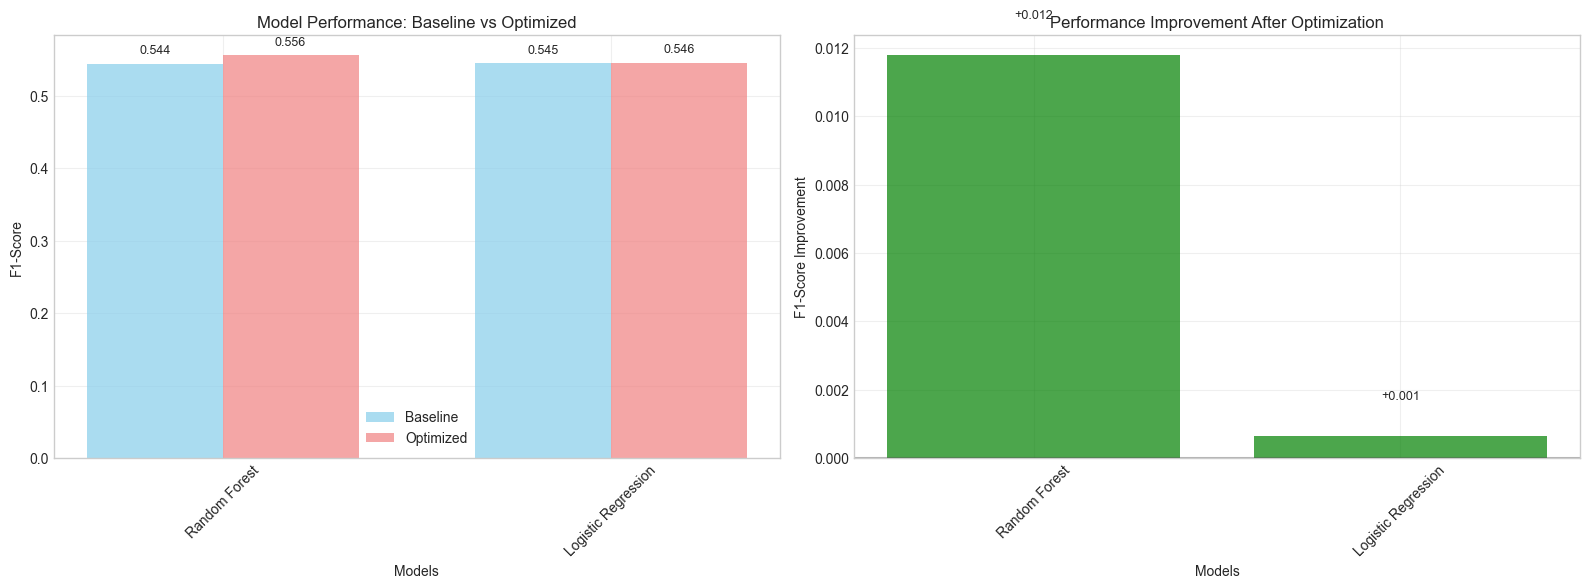

In [ ]:
# Visualize optimization results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# F1-Score comparison
x_pos = np.arange(len(comparison_df))
width = 0.35

ax1.bar(x_pos - width/2, comparison_df['Baseline_F1'], width, label='Baseline', alpha=0.7, color='skyblue')
ax1.bar(x_pos + width/2, comparison_df['Optimized_F1'], width, label='Optimized', alpha=0.7, color='lightcoral')

ax1.set_xlabel('Models')
ax1.set_ylabel('F1-Score')
ax1.set_title('Model Performance: Baseline vs Optimized')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(comparison_df['Model'], rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels
for i, (base, opt) in enumerate(zip(comparison_df['Baseline_F1'], comparison_df['Optimized_F1'])):
    ax1.text(i - width/2, base + 0.01, f'{base:.3f}', ha='center', va='bottom', fontsize=9)
    ax1.text(i + width/2, opt + 0.01, f'{opt:.3f}', ha='center', va='bottom', fontsize=9)

# Improvement visualization
colors = ['green' if imp >= 0 else 'red' for imp in comparison_df['Improvement']]
ax2.bar(comparison_df['Model'], comparison_df['Improvement'], color=colors, alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax2.set_xlabel('Models')
ax2.set_ylabel('F1-Score Improvement')
ax2.set_title('Performance Improvement After Optimization')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

# Add value labels
for i, imp in enumerate(comparison_df['Improvement']):
    ax2.text(i, imp + (0.001 if imp >= 0 else -0.003), f'{imp:+.3f}', 
             ha='center', va='bottom' if imp >= 0 else 'top', fontsize=9)

plt.tight_layout()
plt.show()

## 8. Detailed Analysis of Best Optimized Model

=== DETAILED ANALYSIS OF BEST OPTIMIZED MODEL ===

📋 Random Forest - Detailed Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

  No Disease       0.75      0.84      0.79        82
        Mild       0.46      0.55      0.50        53
    Moderate       0.29      0.18      0.22        22
     Serious       0.33      0.24      0.28        21
      Severe       0.00      0.00      0.00         6

    accuracy                           0.58       184
   macro avg       0.37      0.36      0.36       184
weighted avg       0.54      0.58      0.56       184



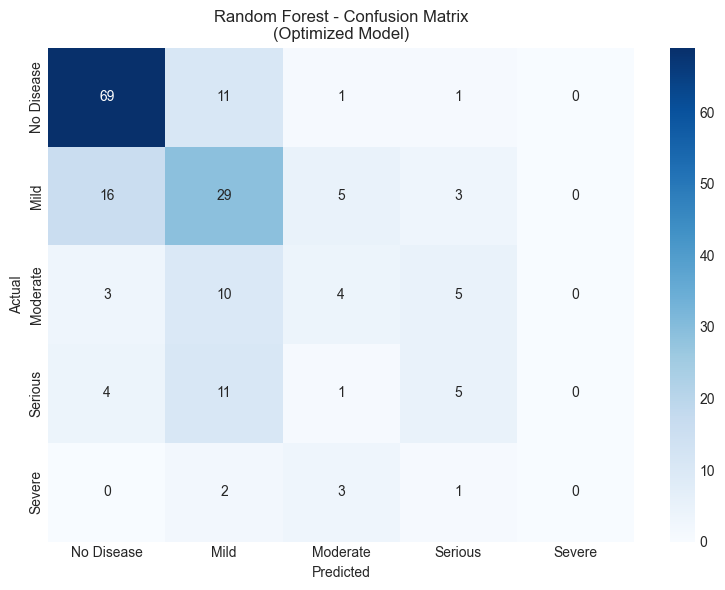


📊 Random Forest - Feature Importance:


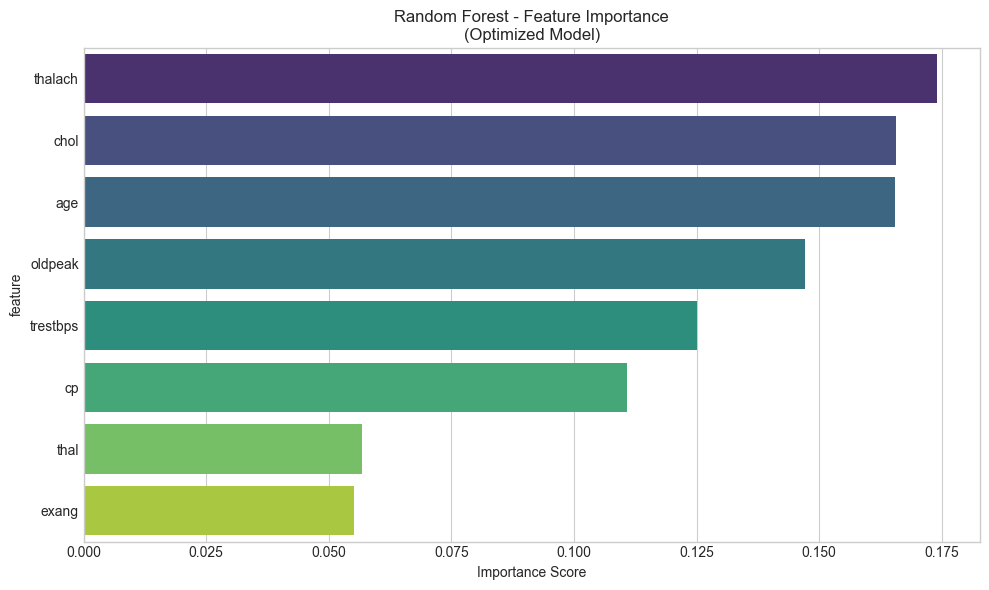

Top 5 most important features:
   thalach: 0.1741
   chol: 0.1656
   age: 0.1655
   oldpeak: 0.1471
   trestbps: 0.1252


In [ ]:
print("=== DETAILED ANALYSIS OF BEST OPTIMIZED MODEL ===\n")

best_model = tuned_models[best_optimized_model]

# Make predictions with best model
y_pred_best = best_model.predict(X_test)
y_pred_proba_best = best_model.predict_proba(X_test) if hasattr(best_model, 'predict_proba') else None

# Detailed classification report
print(f" {best_optimized_model} - Detailed Classification Report:")
print("-" * 60)
class_names = ['No Disease', 'Mild', 'Moderate', 'Serious', 'Severe']
print(classification_report(y_test, y_pred_best, target_names=class_names))

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'{best_optimized_model} - Confusion Matrix\n(Optimized Model)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Feature Importance (if available)
if hasattr(best_model, 'feature_importances_'):
    print(f"\n {best_optimized_model} - Feature Importance:")
    
    importances = best_model.feature_importances_
    feature_imp_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_imp_df, x='importance', y='feature', palette='viridis')
    plt.title(f'{best_optimized_model} - Feature Importance\n(Optimized Model)')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()
    
    print("Top 5 most important features:")
    for i, row in feature_imp_df.head().iterrows():
        print(f"   {row['feature']}: {row['importance']:.4f}")

## 9. Save Optimized Models and Results

In [ ]:
print("=== SAVING OPTIMIZED MODELS & RESULTS ===\n")

# Save all optimized models
for model_name, model in tuned_models.items():
    filename = f'../models/optimized_{model_name.lower().replace(" ", "_")}.pkl'
    joblib.dump(model, filename)
    print(f" Saved optimized {model_name}: {filename}")

# Save the best optimized model separately
best_model_filename = f'../models/final_optimized_{best_optimized_model.lower().replace(" ", "_")}.pkl'
joblib.dump(best_model, best_model_filename)
print(f"\n Saved Best Optimized Model: {best_model_filename}")

# Save optimization results
comparison_df.to_csv('../results/hyperparameter_tuning_comparison.csv', index=False)

# Save detailed optimization parameters
optimization_details = []
for model_name, results in optimization_results.items():
    optimization_details.append({
        'model': model_name,
        'best_params': str(results['best_params']),
        'best_cv_score': results['best_score'],
        'baseline_f1': baseline_results[model_name]['f1_score'],
        'improvement': results['best_score'] - baseline_results[model_name]['f1_score']
    })

pd.DataFrame(optimization_details).to_csv('../results/optimization_parameters.csv', index=False)

# Save final evaluation summary
with open('../results/final_model_summary.txt', 'w') as f:
    f.write("HEART DISEASE CLASSIFICATION - FINAL MODEL SUMMARY\n")
    f.write("=" * 60 + "\n\n")
    f.write(f"FINAL OPTIMIZED MODEL: {best_optimized_model}\n")
    f.write(f"Optimized F1-Score: {best_optimized_f1:.4f}\n")
    f.write(f"Test Accuracy: {optimized_results[best_optimized_model]['accuracy']:.4f}\n")
    f.write(f"Improvement from baseline: {comparison_df.iloc[0]['Improvement']:+.4f}\n\n")
    
    f.write("BEST HYPERPARAMETERS:\n")
    f.write("-" * 40 + "\n")
    for key, value in optimization_results[best_optimized_model]['best_params'].items():
        f.write(f"{key}: {value}\n")

print("\n All optimized models and results saved successfully!")
print(f" Final summary saved: ../results/final_model_summary.txt")


=== SAVING OPTIMIZED MODELS & RESULTS ===

✅ Saved optimized Logistic Regression: ../models/optimized_logistic_regression.pkl
✅ Saved optimized Random Forest: ../models/optimized_random_forest.pkl

🏆 Saved Best Optimized Model: ../models/final_optimized_random_forest.pkl

✅ All optimized models and results saved successfully!
📊 Final summary saved: ../results/final_model_summary.txt

🎉 Hyperparameter Tuning completed!
🚀 Machine Learning Pipeline Finished Successfully!
